##3) Semi-parametric Methods

Cox proportional hazard model estimates the hazard ratio of covariates with respect to a refence value, under the assumption that the estimated hazard ratios are constant (they do not depend on time) although the hazards might change. 

$$h(t)=h_{0}e^{\bf{X^{T}}\bf{\beta}}$$

where $h_{0}$ is the baseline hazard and $e^{\bf{X^{T}}\bf{\beta}}$ is the hazard ratio, $\bf{X}$ are the covariates and $\bf{\beta}$ are the coefficients. The baseline hazard $h_{0}$ is unspecified and is left out of the likelihood function. For this reason the Cox proportional hazards model has a partial likelihood function:

$$ L(\beta)=\prod_{i=1}^{n}\Bigg[\frac{e^{x_{i}^{T}\beta}}{\sum_{k\in{R(t_{i})}}e^{x_{k}^{T}\beta}}\Bigg]^{d_{i}} $$

where $d_{i}$ is the censoring variable that equals to 1 if the an event occured at time $t_{i}$ and to 0 if the unit was censored at time $t_{i}$. Therefore only the units that experience the event contribute to the likelihood function. In the Cox proportional hazards likelihood function, the numerator is the hazard of unit $i$, and the denominator is the sum of the hazards of all units that are still under risk of event (did not experience the event and was not censored before the time at which unit $i$ experienced the event). Note that these hazards do not depend on the value of $t$, it is only the ordering of $t$ that matters.

The assumption is that each event time is unique, and there is only one possible value for the partial likelihood at time $i$. This assumption does not hold for many types of data, including the data set we are working with here. Many groups ended within the first year of their start (these are assumed to have a survival time of 1 year). Because we do not have more precise information on survival times which would have allowed us to have uniqe event times for the groups who have ended, we have to use an approximation method. 
  
The first approximation method is the 'exact method' which finds the likelihood function value for a survival time $i$ as the sum of the probability of each permutation of event time orderings at that time. But this method is computationally too expensive. Instead Efron approximation is often used. Efron approximation likelihood is given by:

$$ L(\beta)=\prod_{i=1}^{n}\Bigg[\frac{e^{x_{i}\beta}}{\prod_{k=1}^{d_{1}}(\sum_{j\in{R_{t_{i}}}} e^{x_{j}\beta}-\frac{k-1}{d_{i}}\sum_{j\in{D_{t_{i}}}}e^{x_{j}\beta})}\Bigg]^{d_{i}}$$

where $d_{i}$ is the number of ties at time $t_{i}$, $D_{t_{i}}$ denotes the units that experienced the event at time $t_{i}$ and $R_{t_{i}}$ denotes the units that are still at risk of event at time $t_{i}$. We can use the CoxPHFitter from Lifelines package to fit a Cox proportional hazards model. The default approximation method in CoxPHFitter is the Efron approximation.

In [14]:
#CoxPHFitter takes a dataframe that includes time and event 
#variables
survivaldata_time_event = survivaldata.copy()
#Remove the constant term, since the Cox proportional hazards model does not estimate a parameter for the constant term
survivaldata_time_event = survivaldata_time_event.iloc[:,:-1]
#Add the time and censoring variables to the dataframe
survivaldata_time_event['Time'] = timevar
survivaldata_time_event['Event'] = eventvar
#Create the CoxPHFitter object
cf = CoxPHFitter()
#Fit the model
cf.fit(survivaldata_time_event, 'Time', event_col='Event',include_likelihood = True)
#Print the summary from the cox-proportional hazard model
cf.print_summary()

n=648, number of events=243

                          coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
Territorial_change  -2.941e-01  7.452e-01 1.002e-01 -2.936e+00 3.329e-03  -4.904e-01  -9.769e-02   **
Policy_change       -7.985e-02  9.233e-01 7.653e-02 -1.043e+00 2.967e-01  -2.299e-01   7.017e-02     
Empire              -9.692e-03  9.904e-01 8.712e-02 -1.112e-01 9.114e-01  -1.805e-01   1.611e-01     
Social_revolution   -1.136e-02  9.887e-01 7.534e-02 -1.508e-01 8.801e-01  -1.591e-01   1.363e-01     
Status_Quo          -3.772e-02  9.630e-01 6.394e-02 -5.900e-01 5.552e-01  -1.631e-01   8.763e-02     
1,000s              -6.789e-02  9.344e-01 1.033e-01 -6.570e-01 5.112e-01  -2.705e-01   1.347e-01     
100s                 1.311e-01  1.140e+00 1.258e-01  1.042e+00 2.974e-01  -1.155e-01   3.777e-01     
10s                  1.375e-01  1.147e+00 1.423e-01  9.664e-01 3.339e-01  -1.415e-01   4.165e-01     
Low_income           3.252e-02  1.033e+00 1.034e-01  

The Cox model suggests that only 'Territorial change' and 'Religious' have significant impact on the hazard of ending, after controlling for all the other variables. Hazard for ending for groups that want territorial change is 0.745 of those who want regime change (the reference category that is left out of the equation). Similarly, religious groups are subject to only 0.62 times the hazard faced by left wing groups at any time. 

These results assume that the risks faced by different groups are proportional to each other. Two ways to test the proportionality assumption are calculating Schoenfeld residuals and plotting log(-log(S(t))) vs. log(time).

We first check whether Schoenfeld residuals are correlated with time to test the proportional hazard assumption. Schoenfeld residuals are defined for each covariate of each individual who experience the event and they equal to the difference between the covariate value of the unit at the time of failure and the expected value of the covariate at the time of failure. The expected value of a covariate is found by multiplying the covariate values of all units still at risk of failure at the time of failure by the probabilities of failure of units. Probability of failure of a unit is calculated by:

$$ P(j\,fails) = \frac{e^{\beta x_{j}}}{\sum_{g\in\mathcal{R_{(t)}}}e^{\beta x_{g}}}$$

where $e^{\beta x_{j}}$ is the hazard of individual $j$ and ${\sum_{g\in\mathcal{R_{(t)}}}e^{\beta x_{g}}}$ is the sum of hazards of all units still at risk of failure (which did not fail and was not lost to follow-up before the time of failure of $j$).

The expected value of the covariate is found by multiplying the probabilities of failure of each unit at risk of failure by their covariate values. 

$$ E(X)=\frac{\sum_{j\in\mathcal{R_{(t)}}}x_{j}e^{\beta x_{j}}}{\sum_{g\in\mathcal{R_{(t)}}}e^{\beta x_{g}}}$$

$$ \hat{r_{j}}=x_{j}-E(X) $$

The scaled Schoenfeld residuals are calculated by weighting the residuals by the variance covariance of covariates.

$$ \hat{r_{j}}= M var(\beta) \hat{r_{j}} $$

where $M$ is the number of events.

If the proportional assumptions hold, scaled schoenfeld residuals should not be correlated with time. 

In [15]:
#This is the function that returns scaled schoenfeld residuals
#y is the 'time' variable, 'X' is the n by p data matrix, 
#'params' is the parameter values from the Cox proportional hazard model
#'covar' is the variance-covariance matrix from the Cox proportional
#hazard model
def schoenfeldresiduals(y,X,event,params,covar):
    #Create a dataframe to hold the scaled Schoenfeld residuals
    schoenfeldresiduals = pd.DataFrame(columns=[X.columns])
    #Create a dataframe to hold the 'Time variable'
    schoenfeldtime = pd.DataFrame(columns=['Time'])
    #Add the 'Time' variable to the data matrix 'X'. This will be
    #useful to select units still at risk of event
    X['Time'] = y
    #Add the 'event' variable to the data matrix 'X'. This will be
    #useful to select units who experienced the event
    X['Eventoccured'] = event
    #Sort 'X' based on time (ascending order)
    X = X.sort(['Time'],axis = 0)
    #Get the number of units
    numberofunits = len(X)
    #Set the counter to zero
    counter = 0
    #Get the number of units that experienced the event
    numberofevents = np.sum(event)
    #For each unit, calculate the residuals if they experienced the event
    for patientindex in xrange(numberofunits):
        if X['Eventoccured'].iloc[patientindex] == 1:
            currenttime = X['Time'].iloc[patientindex]
            #Sum of the hazards for all the observations still at risk
            sumhazards = np.sum(np.exp(np.dot(X.loc[X['Time'] >= currenttime].iloc[:,:len(X.columns) - 2],params)))
            #Calculate the probability of event for each unit still at risk
            probabilityofdeathall = np.ravel(np.exp(np.dot(X.loc[X['Time'] >= currenttime].iloc[:,:len(X.columns) - 2],params)) / sumhazards)         
            #Calculate the expected covariate values
            expectedcovariatevalues = np.dot(probabilityofdeathall,X.loc[(X['Time'] >= currenttime)].iloc[:,:len(X.columns) - 2])
            #Get Schoenfeld residuals as the difference between the current unit's covariate values and the 
            #expected covariate values calculated from all units at risk
            residuals = X.iloc[patientindex,:len(X.columns) - 2] - expectedcovariatevalues
            #Scale the residuals by the variance-covariance matrix of model parameters
            scaledresiduals = numberofevents * np.dot(covar,residuals)
            #Add the scaled residuals to the dataframe for residuals
            schoenfeldresiduals.loc[counter]= scaledresiduals
            #Add the current time for the current unit. This can be used to regress scaled residuals against time
            schoenfeldtime.loc[counter] = currenttime          
            counter = counter + 1
    schoenfeldresiduals['Time'] = schoenfeldtime
    return schoenfeldresiduals

We now calculate the schoenfeld residuals by using the function above.

In [16]:
residuals = schoenfeldresiduals(timevar,survivaldata.iloc[:,:-1],eventvar,cf.hazards_.transpose(),cf.covar())   

Now that we have the scaled schoenfeld residuals for all groups who failed and for each covariate, we can plot them and regress them against time to see if there is a statistically significant correlation. Residuals dispersed randomly around 0 and non-significant correlation coefficients between time and residuals indicate that the proportional hazards assumption holds. A significant coefficient indicates that the proportional hazard is not a suitable assumption (the proportion of risk changes with time).

                            OLS Regression Results                            
Dep. Variable:     Territorial_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1207
Date:                Wed, 18 Nov 2015   Prob (F-statistic):              0.729
Time:                        22:29:49   Log-Likelihood:                -271.69
No. Observations:                 243   AIC:                             547.4
Df Residuals:                     241   BIC:                             554.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Time           0.0014      0.004      0.347      0.7

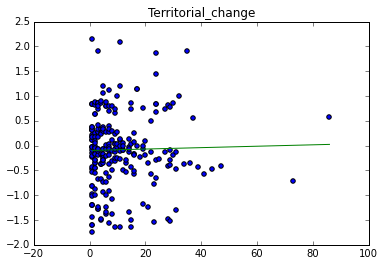

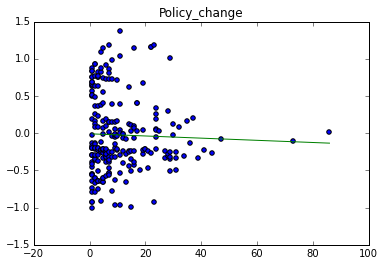

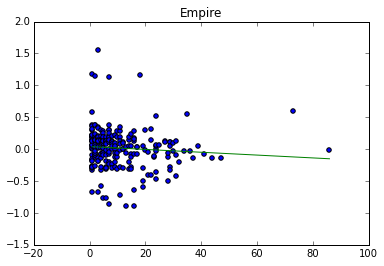

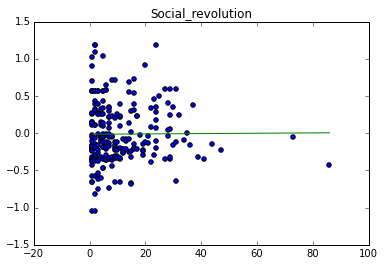

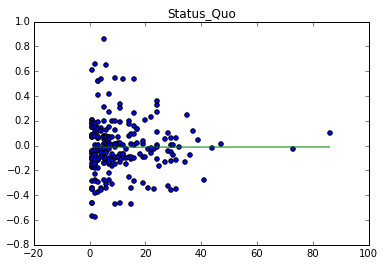

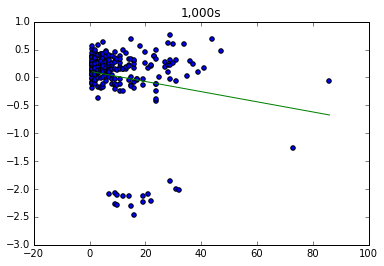

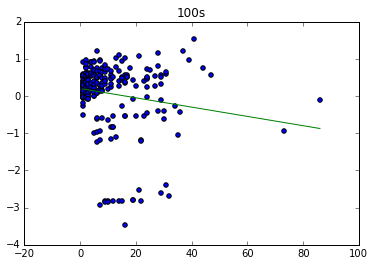

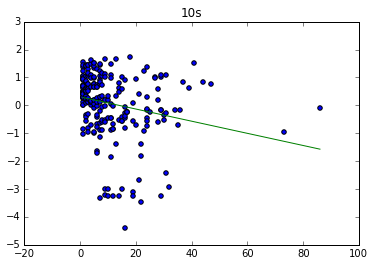

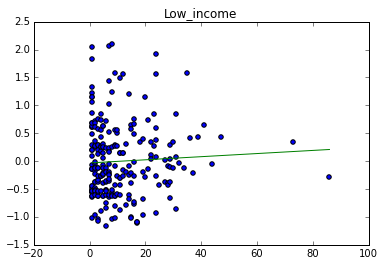

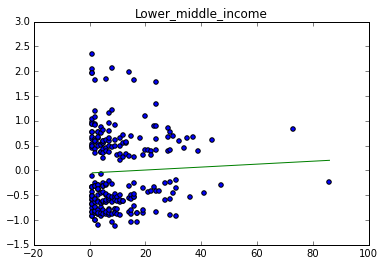

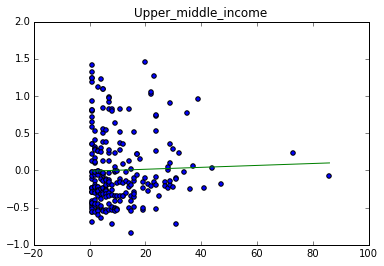

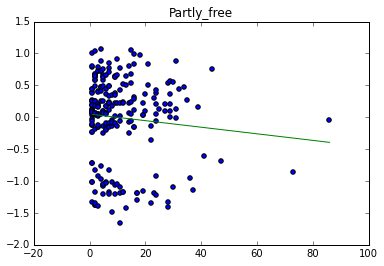

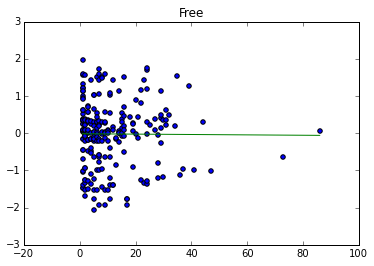

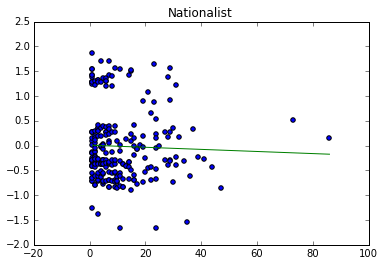

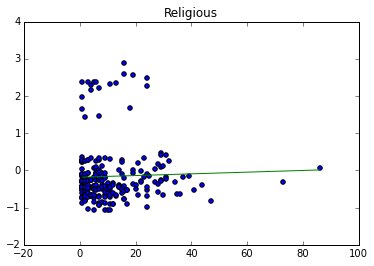

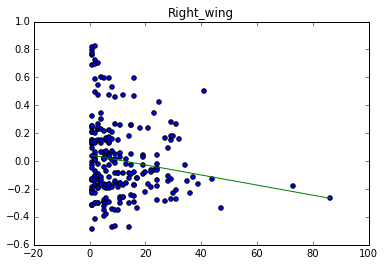

In [17]:
#Start plotting the scaled residuals against time
plt.figure()
plt.scatter(residuals['Time'],residuals['Territorial_change'])
plt.title('Territorial_change')
#Fit a linear model to scaled residuals and time data, after adding a constant
#to 'Time'
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Territorial_change'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

#Repeat for residuals from other variables
plt.figure()
plt.scatter(residuals['Time'],residuals['Policy_change'])
plt.title('Policy_change')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Policy_change'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Empire'])
plt.title('Empire')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Empire'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Social_revolution'])
plt.title('Social_revolution')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Social_revolution'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Status_Quo'])
plt.title('Status_Quo')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Status_Quo'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['1,000s'])
plt.title('1,000s')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['1,000s'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['100s'])
plt.title('100s')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['100s'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['10s'])
plt.title('10s')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['10s'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Low_income'])
plt.title('Low_income')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Low_income'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Lower_middle_income'])
plt.title('Lower_middle_income')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Lower_middle_income'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Upper_middle_income'])
plt.title('Upper_middle_income')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Upper_middle_income'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Partly_free'])
plt.title('Partly_free')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Partly_free'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Free'])
plt.title('Free')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Free'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Nationalist'])
plt.title('Nationalist')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Nationalist'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Religious'])
plt.title('Religious')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Religious'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Right_wing'])
plt.title('Right_wing')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Right_wing'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

Plots and the regressions suggest that the proportional hazards assumption does not hold for '1,000s', '100s', '10s' and 'Right wing' variables. These values do not suggest that we should reject the proportionality assumption for 'Territorial change' and 'Religious' variables.

Another method to check the proportional hazards assumption is to check the plot of log(-log(S(t))) against log(time) where S(t) is calculated by the Kaplan-Meier method described in section 2.

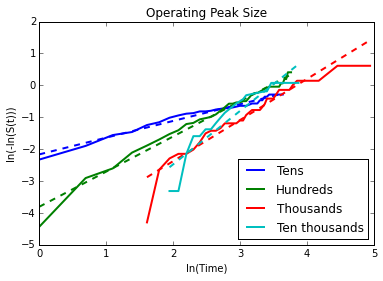

In [19]:
#Start plotting the log(-log(S(t))) against log(t). First, get the Kaplan-Meier estimates for S(t).
plt.figure()
kmf.fit(timevar[tens],event_observed = eventvar[tens],label = "Tens")
#Plot the log(-log(S(t))) against log(t)
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Tens'])),linewidth = 2.0,label = "Tens")
#Fit a linear equation for easier visual assessment of the plots
y = np.log(-np.log(kmf.survival_function_['Tens'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

#Repeat for groups of different peak operating sizes
kmf.fit(timevar[hundreds],event_observed = eventvar[hundreds],label = "Hundreds")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Hundreds'])),linewidth = 2.0,label = "Hundreds")
y = np.log(-np.log(kmf.survival_function_['Hundreds'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[thousands],event_observed = eventvar[thousands],label = "Thousands")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Thousands'])),linewidth = 2.0,label = "Thousands")
y = np.log(-np.log(kmf.survival_function_['Thousands'].iloc[5:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[5:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

kmf.fit(timevar[tenthousands],event_observed = eventvar[tenthousands],label = "Ten thousands")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Ten thousands'])),linewidth = 2.0,label = "Ten thousands")
y = np.log(-np.log(kmf.survival_function_['Ten thousands'].iloc[3:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[3:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'c--',linewidth = 2.0)

plt.legend(loc = 'lower right')
plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Operating Peak Size')

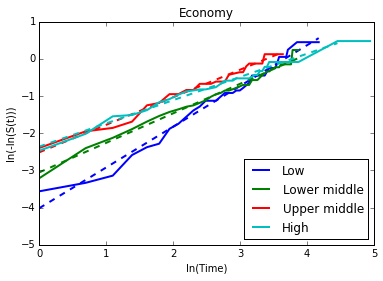

In [20]:
#Repeat for groups operating against countries with different income levels
plt.figure()
kmf.fit(timevar[low],event_observed = eventvar[low],label = "Low")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Low'])),linewidth = 2.0,label = "Low")
y = np.log(-np.log(kmf.survival_function_['Low'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

kmf.fit(timevar[lowermiddle],event_observed = eventvar[lowermiddle],label = "Lower middle")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Lower middle'])),linewidth = 2.0,label = "Lower middle")
y = np.log(-np.log(kmf.survival_function_['Lower middle'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[uppermiddle],event_observed = eventvar[uppermiddle],label = "Upper middle")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Upper middle'])),linewidth = 2.0,label = "Upper middle")
y = np.log(-np.log(kmf.survival_function_['Upper middle'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

kmf.fit(timevar[high],event_observed = eventvar[high],label = "High")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['High'])),linewidth = 2.0,label = "High")
y = np.log(-np.log(kmf.survival_function_['High'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'c--',linewidth = 2.0)

plt.legend(loc = 'lower right')
plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Economy')

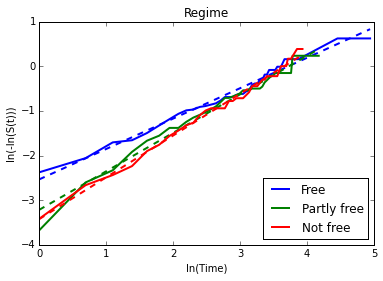

In [21]:
#Repeat for groups operating against countries with different freedom index values
plt.figure()
kmf.fit(timevar[free],event_observed = eventvar[free],label = "Free")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Free'])),linewidth = 2.0,label = "Free")
y = np.log(-np.log(kmf.survival_function_['Free'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

kmf.fit(timevar[partlyfree],event_observed = eventvar[partlyfree],label = "Partly free")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Partly free'])),linewidth = 2.0,label = "Partly free")
y = np.log(-np.log(kmf.survival_function_['Partly free'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[notfree],event_observed = eventvar[notfree],label = "Not free")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Not free'])),linewidth = 2.0,label = "Not free")
y = np.log(-np.log(kmf.survival_function_['Not free'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

plt.legend(loc = 'lower right')
plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Regime')

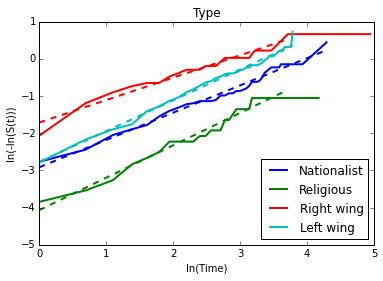

In [22]:
#Repeat for groups with different ideologies
plt.figure()
kmf.fit(timevar[nationalist],event_observed = eventvar[nationalist],label = "Nationalist")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Nationalist'])),linewidth = 2.0,label = "Nationalist")
y = np.log(-np.log(kmf.survival_function_['Nationalist'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

kmf.fit(timevar[religious],event_observed = eventvar[religious],label = "Religious")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Religious'])),linewidth = 2.0,label = "Religious")
y = np.log(-np.log(kmf.survival_function_['Religious'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[right_wing],event_observed = eventvar[right_wing],label = "Right wing")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Right wing'])),linewidth = 2.0,label = "Right wing")
y = np.log(-np.log(kmf.survival_function_['Right wing'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

kmf.fit(timevar[left_wing],event_observed = eventvar[left_wing],label = "Left wing")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Left wing'])),linewidth = 2.0,label = "Left wing")
y = np.log(-np.log(kmf.survival_function_['Left wing'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'c--',linewidth = 2.0)

plt.legend(loc = 'lower right')
plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Type')

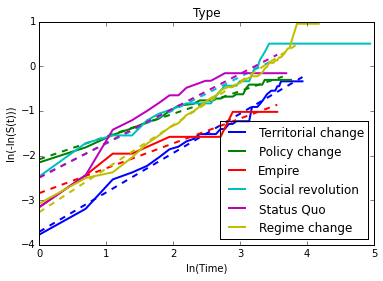

In [23]:
#Repeat for groups with different goals
plt.figure()
kmf.fit(timevar[territorial],event_observed = eventvar[territorial],label = "Territorial change")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Territorial change'])),linewidth = 2.0,label = "Territorial change")
y = np.log(-np.log(kmf.survival_function_['Territorial change'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

kmf.fit(timevar[policy],event_observed = eventvar[policy],label = "Policy change")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Policy change'])),linewidth = 2.0,label = "Policy change")
y = np.log(-np.log(kmf.survival_function_['Policy change'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[empire],event_observed = eventvar[empire],label = "Empire")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Empire'])),linewidth = 2.0,label = "Empire")
y = np.log(-np.log(kmf.survival_function_['Empire'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

kmf.fit(timevar[social],event_observed = eventvar[social],label = "Social revolution")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Social revolution'])),linewidth = 2.0,label = "Social revolution")
y = np.log(-np.log(kmf.survival_function_['Social revolution'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'c--',linewidth = 2.0)

kmf.fit(timevar[status],event_observed = eventvar[status],label = "Status Quo")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Status Quo'])),linewidth = 2.0,label = "Status Quo")
y = np.log(-np.log(kmf.survival_function_['Status Quo'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'m--',linewidth = 2.0)

kmf.fit(timevar[regime],event_observed = eventvar[regime],label = "Regime change")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Regime change'])),linewidth = 2.0,label = "Regime change")
y = np.log(-np.log(kmf.survival_function_['Regime change'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'y--',linewidth = 2.0)

plt.legend(loc = 'lower right')
plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Type')

Plots and the regression results indicate that the proportionality of hazards assumption does not hold for '1,000s', '100s' and '10s', and 'right wing' variables, consistent with the results from scaled residual variables.

Next, we will use parametric methods to model the time to end data.